In [75]:
#importações

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.signal
from skimage.segmentation import active_contour
from skimage import color
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

import pandas as pd

In [76]:
df = pd.read_csv('data/labels.csv')

# Encontrar as imagens representativas para cada categoria
gon_high_q = df[(df['Label'] == 'GON+') & (df['Quality Score'] > 6)].iloc[0]
gon_low_q = df[(df['Label'] == 'GON+') & (df['Quality Score'] < 6) & (df['Quality Score'] > 5)].iloc[0]
healthy_high_q = df[(df['Label'] == 'GON-') & (df['Quality Score'] > 6)].iloc[0]
healthy_low_q = df[(df['Label'] == 'GON-') & (df['Quality Score'] < 6) & (df['Quality Score'] > 5)].iloc[0]

In [77]:
# Create a tidy DataFrame with the four representative rows
examples = pd.DataFrame([gon_high_q, gon_low_q, healthy_high_q, healthy_low_q])
examples = examples.reset_index(drop=True)
examples.index = ['GON+ (high Q)', 'GON+ (low Q)', 'GON- (high Q)', 'GON- (low Q)']
examples.columns = [c.strip() for c in examples.columns]
display(examples)

,Image Name,Patient,Label,Quality Score,Unnamed: 4
GON+ (high Q),0_0.jpg,0,GON+,6.18,NaN
GON+ (low Q),1_0.jpg,1,GON+,5.31,NaN
GON- (high Q),187_0.jpg,187,GON-,7.26,NaN
GON- (low Q),189_2.jpg,189,GON-,5.63,NaN


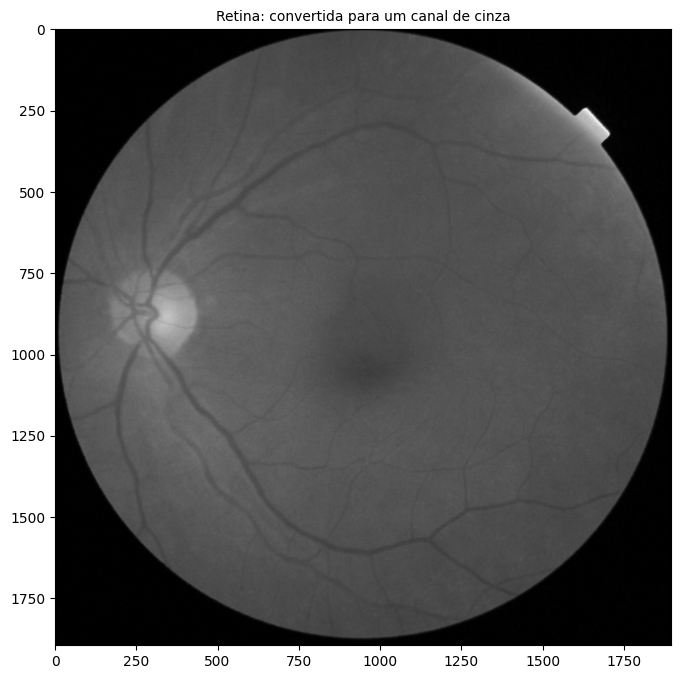

In [78]:
retina_img = cv2.imread(filename='data/images/187_0.jpg') # Load the image
r,g,b = cv2.split(retina_img) # separa os canais
retina_gray = cv2.cvtColor(retina_img,cv2.COLOR_BGR2GRAY) # coverte para cinza
plt.figure(figsize = (8,8))
plt.title("Retina: convertida para um canal de cinza", fontsize=10)
plt.imshow(retina_gray, cmap='gray')
plt.show()

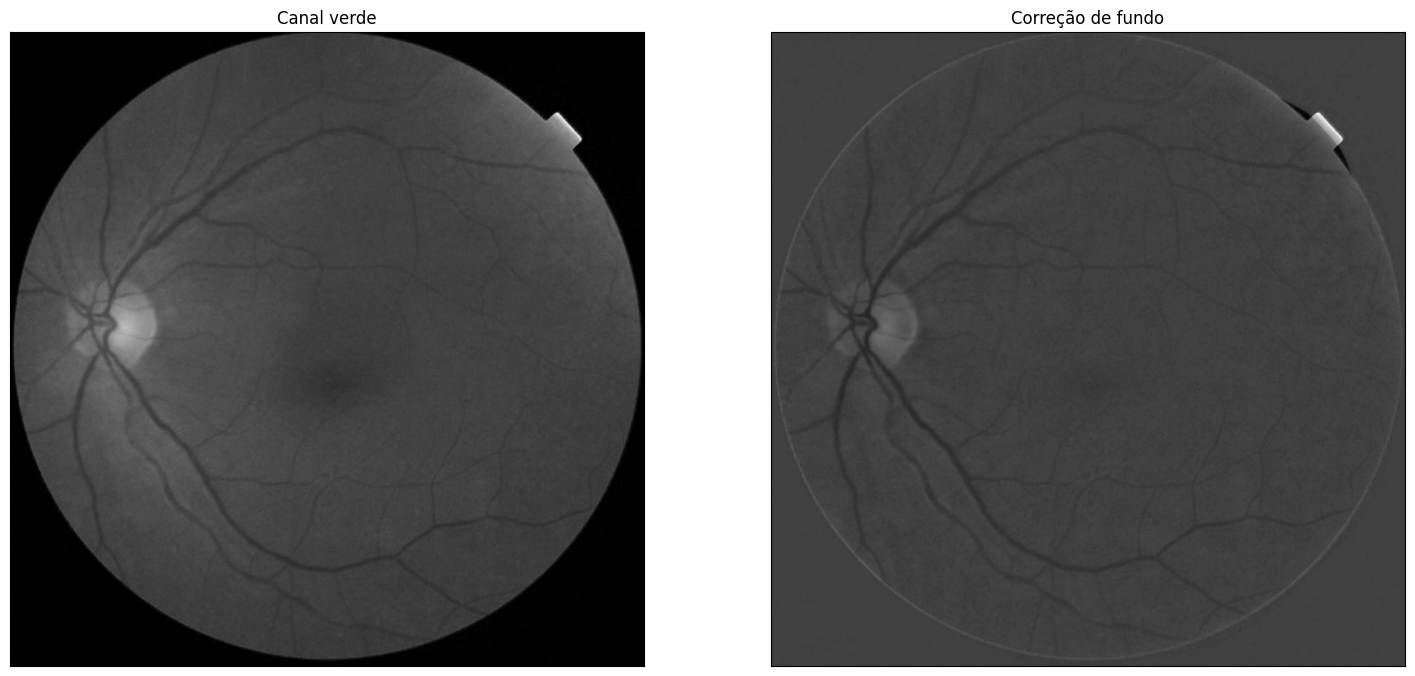

In [79]:
def corrige_fundo(green_c):
    img = cv2.addWeighted(green_c, 0.5, ~cv2.medianBlur(green_c, 201), 0.5, 0)
    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # img = clahe.apply(img)
    fig = plt.figure(figsize=(18,9))
    plt.subplot(121),plt.imshow(green_c, cmap='gray'),plt.title('Canal verde')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img, cmap='gray'),plt.title('Correção de fundo')
    plt.xticks([]), plt.yticks([])
    plt.show()

    return img

# verde da primeira imagem com correção de tonalidade
green_ton = corrige_fundo(g)

C:\Users\arthu\AppData\Local\Temp\ipykernel_46604\1555240246.py:3: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  img2 = ndi.filters.gaussian_filter(img, 2)


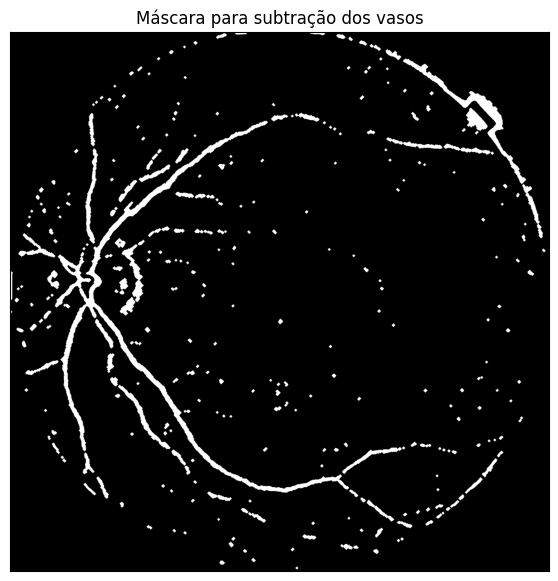

In [85]:
def subtrai_vasos(img):

    img2 = ndi.filters.gaussian_filter(img, 2)
    th = cv2.adaptiveThreshold(
        img,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        105,
        2
    )
    '''
    kernel = np.array(
        ([0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]),
        np.uint8
    )
    th = cv2.erode(th, kernel, iterations=5)
    th = cv2.dilate(th, kernel, iterations=7)
    '''
    clean_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, clean_kernel, iterations=3)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, clean_kernel, iterations=5)
    

    fig = plt.figure(figsize=(18,7))
    plt.imshow(th, cmap='gray')
    plt.title('Máscara para subtração dos vasos')
    plt.xticks([]),plt.yticks([])
    plt.show()

    return th

#blood_vessels_1 = blood_vessel_subtraction(green_ton)
vasos = subtrai_vasos(green_ton)

## K Means

In [81]:
eye_float = green_ton.reshape((-1, 1)).astype(np.float32) # vamos usar o canal verde corrigido
criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0) # Estabelece critério para finalização do processo
K = 4 # Número de regiões
attempts=3
# Abaixo, as duas opções de estimativas dos centros iniciais, randômica e
ret,label,center=cv2.kmeans(eye_float,K,None,criterio,attempts,cv2.KMEANS_PP_CENTERS)
ret_rd,label_rd,center_rd=cv2.kmeans(eye_float,K,None,criterio,attempts,cv2.KMEANS_RANDOM_CENTERS)

# Compõe a imagem segmentada no formato da original
center8 = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((green_ton.shape))
center8_rd = np.uint8(center_rd)
res_rd = center[label_rd.flatten()]
res2_rd = res_rd.reshape((green_ton.shape)) # formata a imagem segmentada no formato da original

(Text(0.5, 1.0, 'Imagem segmentada pp para K = 4'), ([], []), ([], []))

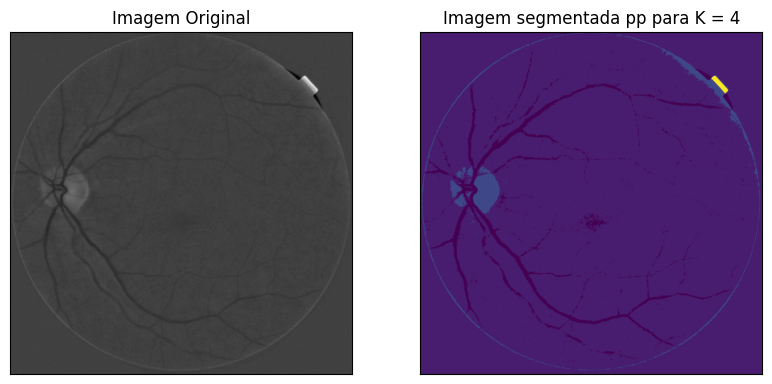

In [82]:
# Apresenta o resultado ao lado da imagem original
figure_size = 15

plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,3,1),plt.imshow(green_ton, cmap='gray')
plt.title('Imagem Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(res2)
plt.title('Imagem segmentada pp para K = %i' % K), plt.xticks([]), plt.yticks([])

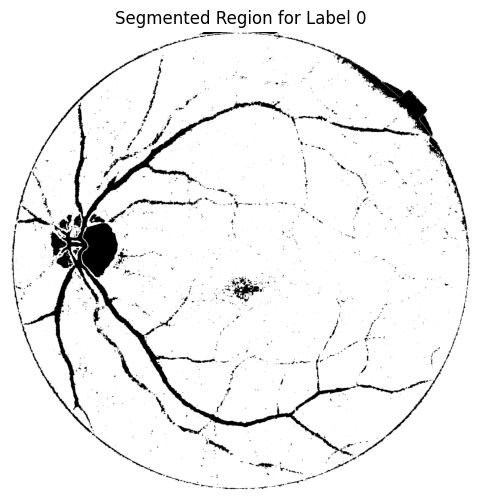

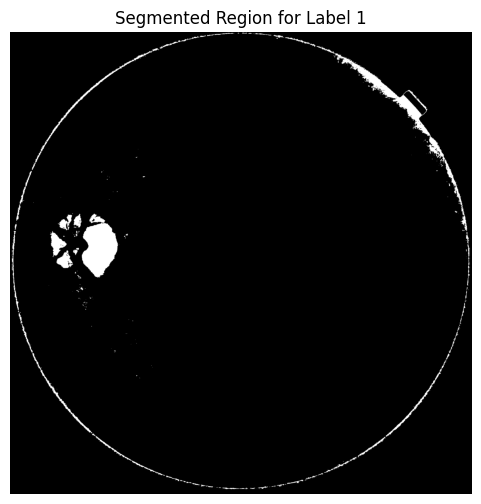

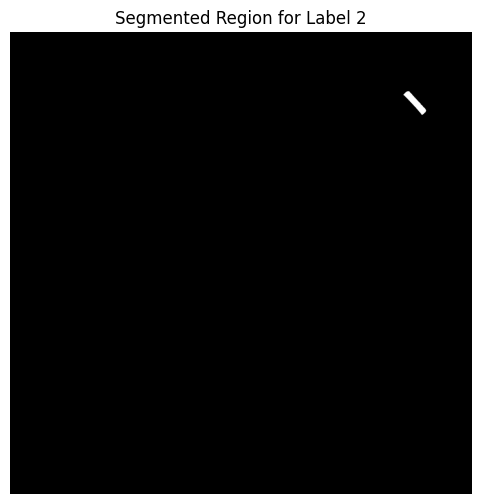

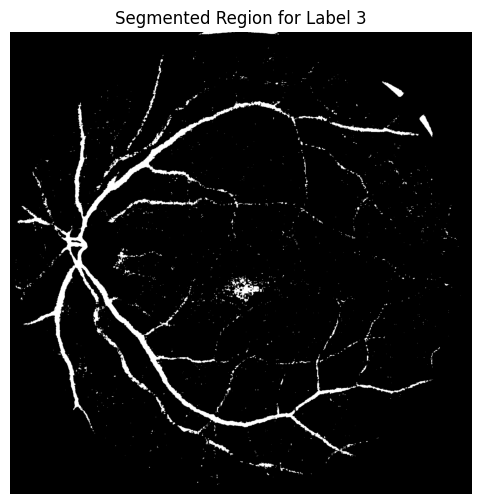

In [83]:
# Novamente, vamos observar separadamente cada região segmentada
for k in range(K):

    mask = (label.flatten() == k).astype(np.uint8)  # Máscara binária para cada k
    segmented_image = res * mask[:, np.newaxis]  # aplica a máscara ao longo do eixo dos pixels
    segmented_image = segmented_image.reshape(green_ton.shape)
    segmented_image = np.clip(segmented_image, 0, 255).astype(np.uint8)
    # Exibe os segmentos
    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_image, cmap='gray')  # Usa cmap='gray'
    plt.title(f'Segmented Region for Label {k}')
    plt.axis('off')
    plt.show()